## 1. Initializer

In [1]:
from __future__ import unicode_literals

import csv
import json
import glob
import os
import re
import sys
import time
import requests
import traceback
from builtins import open
from time import sleep
import urllib.parse
from time import sleep
from pprint import pprint as pp
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from IPython.display import Image, display
import ipyplot

def cleaning_data():
    # 엑셀파일 열기
    data = pd.read_csv('org_ssgi.csv', encoding="utf-8", sep="|", na_filter= False, error_bad_lines=False)
    data = data[data['상권업종대분류명'] == '음식']
    frenchise_data = data[data['지점명']!=""]
    non_frenchise_data = data[data['지점명']==""]
    frenchise_data = frenchise_data.filter(items=['상가업소번호', '상호명', '지점명', '상권업종대분류명', '상권업종중분류명', '시군구명', '지번주소', '도로명주소', '경도', '위도'])
    non_frenchise_data = non_frenchise_data.filter(items=['상가업소번호', '상호명', '지점명', '상권업종대분류명', '상권업종중분류명', '시군구명', '지번주소', '도로명주소', '경도', '위도'])
    return frenchise_data, non_frenchise_data
 
def save_json(json_data, file_name):
    with open(file_name, "w", encoding = 'utf8') as json_file:
        json.dump(json_data, json_file, indent=4, ensure_ascii=False)

def read_json(file_name):
    json_data = {}
    with open(file_name, encoding = 'utf8') as json_file:
        json_data = json.load(json_file)
    return json_data

def sortFunc(e):
    return e[1]

## 2. Feed Manage

*option : filter_thresh_hold(number of comment or reply to discard)*

1. combine all crawled data into one dataset
2. create table converting id to user or table
3. make divided pivot_table (user, post)
4. (continue in next code cell) combine pivot_table...
5. (continue in next code cell) calculate cosine similarity
6. (continue in next code cell) Item based C.F. sort and recommend by cosine similarity 

In [2]:
#
filter_thresh_hold = 2
# load user data
first_iter_users = read_json("feedData/first_iter_users.json")
second_iter_users = read_json("feedData/second_iter_users.json")
third_iter_users = read_json("feedData/third_iter_users.json")
forth_iter_users = read_json("feedData/forth_iter_users.json")
five_iter_users= read_json("feedData/forth_iter_users_backup.json")
jieun_first_iter_users = read_json("feedData/jieun_first_iter_users.json")
jieun_second_iter_users = read_json("feedData/jieun_second_iter_users.json")
jieun_third_iter_users = read_json("feedData/jieun_third_iter_users.json")
jieun_forth_iter_users = read_json("feedData/jieun_forth_iter_users.json")
jieun_five_iter_users = read_json("feedData/jieun_forth_iter_users_backup.json")
# combining users
all_crawlered_users = first_iter_users + second_iter_users + third_iter_users + jieun_first_iter_users + jieun_second_iter_users + jieun_third_iter_users
all_crawlered_users += five_iter_users + forth_iter_users + jieun_forth_iter_users + jieun_five_iter_users
new_users_for_crawling = {}
total_users = {}
for user in all_crawlered_users:
    user["replys"] = []
    total_users[user['id']] = user
# load post data
first_iter_posts = read_json("feedData/first_iter_posts.json")
second_iter_posts = read_json("feedData/second_iter_posts.json")
third_iter_posts = read_json("feedData/third_iter_posts.json")
forth_iter_posts = read_json("feedData/forth_iter_posts.json")
five_iter_posts = read_json("feedData/forth_iter_posts_backup.json")
jieun_first_iter_posts = read_json("feedData/jieun_first_iter_posts.json")
jieun_second_iter_posts = read_json("feedData/jieun_second_iter_posts.json")
jieun_third_iter_posts = read_json("feedData/jieun_third_iter_posts.json")
jieun_forth_iter_posts = read_json("feedData/jieun_forth_iter_posts.json")
jieun_five_iter_posts = read_json("feedData/jieun_forth_iter_posts_backup.json")
# combine post data
all_crawlered_posts = first_iter_posts + second_iter_posts + third_iter_posts + jieun_first_iter_posts + jieun_second_iter_posts + jieun_third_iter_posts
all_crawlered_posts += forth_iter_posts + five_iter_posts + jieun_forth_iter_posts + jieun_forth_iter_posts + jieun_five_iter_posts
temp_posts = []
for posts in all_crawlered_posts:
    temp_posts += posts
all_crawlered_posts = temp_posts
# distribute comment to users
total_comments_len = 0
for post in all_crawlered_posts:
    post['replys'] = list(set(list(filter(lambda a: a != post['userID'], post['replys']))))
    total_comments_len += len(post['replys'])
#     post['replys'].append(post['userID'])
    for username in post['replys']:
        if username not in total_users:
            total_users[username] = {'replys':[]}
        total_users[username]["replys"].append(post['img_url'])
print("before filtered comment", total_comments_len)
# filtering user commenting lower than 2
temp_total_users = {}
filtered_user_set = set()
print(len(total_users))
for key, value in total_users.items():
    if len(value["replys"]) > filter_thresh_hold:
        temp_total_users[key] = value
    else:
        filtered_user_set.add(key)
total_users = temp_total_users
total_comments_len = 0
# filtering posts commenting lower than 2
temp_total_posts = []
for value in all_crawlered_posts:
    value['replys'] = list(filter(lambda a: a not in filtered_user_set, value['replys']))
    total_comments_len += len(value['replys'])
    if len(value["replys"]) >= 0:
        temp_total_posts.append(value)
all_crawlered_posts = temp_total_posts
print("after filtered comment", total_comments_len)
# numbering post
post_url_id = {}                           
for id in range(len(all_crawlered_posts)):
    all_crawlered_posts[id]['id'] = id
    post_url_id[all_crawlered_posts[id]['img_url']] = id
# convert url to post id
for key, value in total_users.items():
    temp = []
    for url in value['replys']:
        if url in post_url_id:
            temp.append(post_url_id[url])
    value['comment_articles'] = temp
# convert user dict data to list
list_total_users = list(total_users.values())
for idx, user in enumerate(list_total_users):
    user['id'] = idx
dict_user_data = {user['id']:user for user in list_total_users}
# convert post data to dict
# convert user reply nameName to userID
for post in all_crawlered_posts:
    temp = []
    for username in post['replys']:
        if username in total_users:
            temp.append(total_users[username]['id'])
    post['comment_articles'] = temp
dict_post_data = {post['id']:post for post in all_crawlered_posts}
## Variable Definition
## list : list_total_users, all_crawlered_posts
## dict : dict_user_data, dict_post_data (key : numbering id)
## dict : total_users (key : username)
# convert to sparse vector
total_user_len = len(list(all_crawlered_posts))
total_post_len = len(list(list_total_users))
print(total_user_len)
print(total_post_len)
def cov2sparse(dense, type=0):
    length = total_user_len
    if type == 1:
        length = total_post_len
    sparse = []
    for key in range(length):
        if key in dense:
            sparse.append(1)
        else:
            sparse.append(0)
    return sparse
# post user sparse vector
post_user_rating = []
for post in tqdm(all_crawlered_posts):
    post_user_rating.append(cov2sparse(post['comment_articles'], type=1))
# post user sparse vector
# user_post_rating = []
# for user in tqdm(list_total_users):
#     user_post_rating.append(cov2sparse(user['comment_articles']))
# save as json
# save_json(post_user_rating, "feedDataCombined/post_user_rating.json")
# save_json(user_post_rating, "feedDataCombined/user_post_rating.json")
# save as csv
# df = pd.Dataframe(post_user_rating)
# df.save_csv("feedDataCombined/list_total_users.csv")
# df = None
save_json(list_total_users, "feedDataCombined/list_total_users.json")
save_json(all_crawlered_posts, "feedDataCombined/list_total_posts.json")
save_json(dict_user_data, "feedDataCombined/dict_total_users.json")
save_json(dict_post_data, "feedDataCombined/dict_total_posts.json")
save_json(total_users, "feedDataCombined/dict_totabl_users_name.json")

before filtered comment 248554
55274
after filtered comment 202034


  0%|                                                                              | 14/24829 [00:00<02:57, 139.71it/s]

24829
16964


100%|███████████████████████████████████████████████████████████████████████████| 24829/24829 [02:46<00:00, 149.19it/s]


## 3. CF 

1. option 1 : itemBased 
2. option 2 : matrix factorization


In [3]:
option = 1
item_based_cf = None
matrix_factorization = None
if option == 1:
    item_based_cf = cosine_similarity(post_user_rating).argsort()[:, ::-1]
else:
    SVD = TruncatedSVD(n_components=12)
    matrix = SVD.fit_transform(post_user_rating)
    matrix_factorization = np.corrcoef(matrix).argsort()[:, ::-1]
def get_recommend(feedID, top=10):
    if option == 1:
        sim_index = item_based_cf[feedID, :top].reshape(-1)
        sim_index = sim_index[sim_index != feedID]
        return sim_index
    else:
        sim_index = matrix_factorization[feedID, :top].reshape(-1)
        sim_index = sim_index[sim_index != feedID]
        return sim_index  
def save_image(id, pic_url):
    with open(f'pic{id}.jpg', 'wb') as handle:
            response = requests.get(pic_url, stream=True)

            if not response.ok:
                print(response)

            for block in response.iter_content(1024):
                if not block:
                    break

                handle.write(block)
# Load image from local storage
def get_recommendation(feed_id):
    save_image("target", all_crawlered_posts[feed_id]['img_url'])
    display(Image(filename = "pictarget.jpg", width = 300, height = 300))
    image_array = []
    print(get_recommend(feed_id))
    for id in get_recommend(feed_id):
        save_image(id, all_crawlered_posts[id]['img_url'])
        plt.figure()
        image_array.append(f"pic{id}.jpg")
    ipyplot.plot_images(image_array, max_images=20, img_width=150)

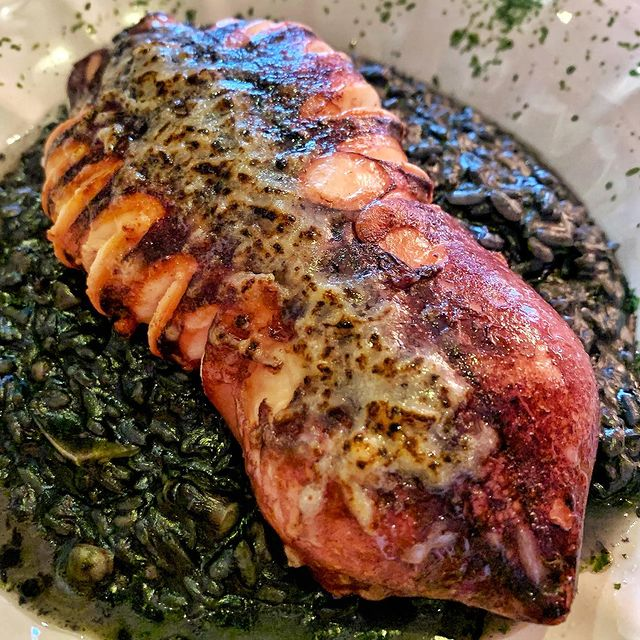

[ 9277  2394   403   507  6320 15211  9495 13802  1493]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
get_recommendation(400)